# Setup

## Imports

In [1]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)

# Lappi
sys.path.insert(1, 'C:/Users/Niklas/Documents/MBI/Master Arbeit/Data/Eval')

# Computer
#sys.path.insert(1, r'C:/Users/Niklas/MBI/Masterarbeit/Evaluation/trsaxs-master-eval/Eval')

import AzimutalIntegration
#import mbistyles

In [2]:
#import dask_image.imread
#import dask_image.ndfilters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#import dask
from skimage.io import imsave, imread
#import dask.array as da
from dask.distributed import Client
from scipy.signal import convolve2d
from skimage.feature import peak_local_max
from pathlib import Path
from PIL import Image
import matplotlib.patches as patches
import matplotlib.cm as cm


import ultrafastFitFunctions as ufff  #!pip install ultrafastfitfunctions
from ultrafastFitFunctions.peaks import gauss
import lmfit as lm                    #!pip install lmfit

#import pyEvalData as ped

%load_ext autoreload
%autoreload 2

#imports for azimuthal integration

import pyFAI
pyFAI.disable_opencl=True # get rid of annoying warning ;)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector

from numpy import *

In [3]:
%matplotlib widget

## Paths

In [4]:
# Laptop
path = 'C:/Users/Niklas/Documents/MBI/Master Arbeit/Data/20230131_correct_offset/scan%d.npy'
up_path = 'C:/Users/Niklas/Documents/MBI/Master Arbeit/Data/20230131_correct_offset/unpumped%d.npy'
p_path = 'C:/Users/Niklas/Documents/MBI/Master Arbeit/Data/20230131_correct_offset/pumped%d.npy'
im_path = 'C:/Users/Niklas/tubCloud/MBI/Data/images/images/image_%d.npz'

In [5]:
# PC
path = 'C:/Users/Niklas/MBI/Masterarbeit/Evaluation/trsaxs-master-eval/20230131_correct_offset/scan%d.npy'
up_path = 'C:/Users/Niklas/MBI/Masterarbeit/Evaluation/trsaxs-master-eval/20230131_correct_offset/unpumped%d.npy'
p_path = 'C:/Users/Niklas/MBI/Masterarbeit/Evaluation/trsaxs-master-eval/20230131_correct_offset/pumped%d.npy'
im_path = 'C:/Users/Niklas/tubCloud/Data/images/images/image_%d.npz'

## Functions

### load images and scans

In [5]:
def load_saved_scan(num, offset, path):
    
    '''
    This function loads a saved scan from image path
    
    
    Note: this is an old version for old .npy array saved data, use load image instead
    '''
    try:
        scan = np.load(path %num, allow_pickle=True)    
    except Exception as e:
        print('Scan no. %i could not load. \nError:' %num)
        print(e)
    
    return scan

def load_image(num, path):
    
    '''
    This function loads a single image from a .npz file in given path.
    
    Params
    ======
    num: int
        number of image which should be loaded
    path: string
        path where the image is located
        
    Returns
    =======
    image: dict of np.arrays
        the image as dict with one array for pumped and one array for the unpumped image
    '''
    
    try:
        image = np.load(path %num, allow_pickle=True)
    except Exception as e:
        print('Scan no. %i could not load. \nError:' %num)
        print(e)
    
    return image

def load_unpumped(num, up_path):
    
    try:
        unpumped = np.load(up_path %num, allow_pickle=True)     
    except Exception as e:
        print('Scan no. %i could not load. \nError:' %num)
        print(e)
    
    return unpumped

def load_pumped(num, p_path):
    
    try:
        pumped = np.load(p_path %num, allow_pickle=True)
    except Exception as e:
        print('Scan no. %i could not load. \nError:' %num)
        print(e)
    
    return pumped

#def load_scan(nums, path, t=(100, 200)):
    
#    for num in nums:
#        load_image(num, path)

In [6]:
def get_vmin_vmax(img_mean_arr, minimum, maximum):
    
    vmin, vmax = np.percentile(img_mean_arr, (minimum, maximum))
    
    return vmin, vmax

In [7]:
def get_meaned_scan(ims, path, minimum=0.1, maximum=97.9):
    
    list_unpumped = []
    list_pumped = []
        
    for image in ims:
        imgs = load_image(image, path)
        
        imgs_pumped = imgs['pumped']
        imgs_unpumped = imgs['unpumped']
        
        list_unpumped.append(np.copy(imgs_unpumped))
        list_pumped.append(np.copy(imgs_pumped))

    array_unpumped = np.array(list_unpumped)
    array_pumped = np.array(list_pumped)
        
    unpumped_mean = np.mean(array_unpumped, axis=0)     
    pumped_mean = np.mean(array_pumped, axis=0) 
    
    vmin, vmax = get_vmin_vmax(unpumped_mean, minimum, maximum)
    
    return unpumped_mean, pumped_mean, vmin, vmax

### masking and get center for PyFAI

In [8]:
def get_mask():
    
    y1_mask, y2_mask = ax.get_ylim()
    x1_mask, x2_mask = ax.get_xlim()

    # sets the correct position of the mask
    mask = np.ones([400,400])
    mask[40:360,40:360] = 0
    mask[int(y2_mask):int(y1_mask), int(x1_mask):int(x2_mask)] = 1
    
    return mask

In [9]:
def invert_mask(mask):
    new_mask = 1-mask
    
    return new_mask

In [10]:
def show_mask_img(img, mask):
    fig, ax = plt.subplots()
    ax.imshow(img['unpumped'], vmin=0, vmax = 0.11)
    ax.imshow(mask, alpha=0.8)

In [11]:
def show_center_ring(radi, img, center):
    radi = radi
    mask_circ = np.zeros((np.shape(img['pumped'])[0],np.shape(img['pumped'])[0]))

# Create Ring mask
    for radius in radi:
        mask_circ = mask_circ + circle_mask(mask_circ.shape,(center[1],center[0]),radius)
 
    fig, ax = plt.subplots()
    ax.imshow(img['pumped'], vmin=0, vmax = 0.11)
    ax.imshow(mask_circ,alpha=0.6)
    plt.tight_layout()

In [12]:
def get_center_pos():
    y1_center, y2_center = ax.get_ylim()
    x1_center, x2_center = ax.get_xlim()
    center = (int((x1_center+x2_center)/2),int((y1_center+y2_center)/2))
    
    return center

In [13]:
def circle_mask(shape,center,radius):

    '''
    Draws circle mask with option to apply gaussian filter for smoothing
    
    Parameter
    =========
    shape : int tuple
        shape/dimension of output array
    center : int tuple
        center coordinates (ycenter,xcenter)
    radius : scalar
        radius of mask in px. Care: diameter is always (2*radius+1) px
    sigma : scalar
        std of gaussian filter
        
    Output
    ======
    mask: array
        binary mask, or smoothed binary mask        
    ======
    author: ck 2022
    '''
    
    #setup array
    x = np.linspace(0,shape[1]-1,shape[1])
    y = np.linspace(0,shape[0]-1,shape[0])
    X,Y = np.meshgrid(x,y)

    # define circle
    mask = np.sqrt(((X-center[1])**2+(Y-center[0])**2)) <= (radius)
    mask = mask.astype(float)

    return mask

### getting x range from Sardana scans

In [14]:
def get_interval_from_sardana(string):
        
        
        """
        Sardana rscan command parser
        input: Str;  Sardana rscan command in the shape:
        -100.0 [[-30 5][30 12][100 8][2000 15]]
        
        
        please add option to give a str in the shape of:
        
        -100.0 [[-30.0, 5], [30.0, 12], [100.0, 8], [2000.0, 15]]
        
        with commas, as scanhist returns it this way. thx
        
        """
        
        splitted = string.split()
        start_pos = float(splitted[0])
        intervall_strings = " ".join(splitted[1:])
        regions = eval(intervall_strings.replace("][","],[").replace(" ", ","))
        region_start = start_pos
        interval = np.array([])
        for r in range(len(regions)):
            region_stop, region_nr_intervals = regions[r][0], regions[r][1]
            positions = np.linspace(region_start, region_stop, region_nr_intervals + 1)
            if r != 0:
                positions = positions[1:]
            interval = np.concatenate((interval, np.array(positions)))
            region_start = region_stop
        return interval

## getting correct x-Values for delay scans

In [15]:
command1 = '-50.0 [[-10.0 5] [30.0 10] [2000.0 25]]'   # 40 pts 
x1 = get_interval_from_sardana(command1)


command2 = '-50.0 [[-10.0 5] [80.0 9] [500.0 8] [2000.0 12]]'  # 34 pts.
x2 = get_interval_from_sardana(command2)

command3 = '-50.0 [[-10.0 5] [80.0 12] [500.0 9] [2000.0 12]]'  # 37 pts .
x3 = get_interval_from_sardana(command3)

command4 = '-60.0 [[-10.0 7] [70.0 14] [500.0 9] [2000.0 12]]'  # 37 pts .
x4 = get_interval_from_sardana(command4)

# PyFAI Setup

## <font color='red'>set scan ID for current elvaluation</font>

In [20]:
#### First image from current scan ####
#scan_id = 
#masking_image = get_first(scan_id, scan_path)

## load single image from scan to set the center position

In [16]:
# load a test image from corresponding scan
im3826 = load_image(3826, im_path)

## Define Mask

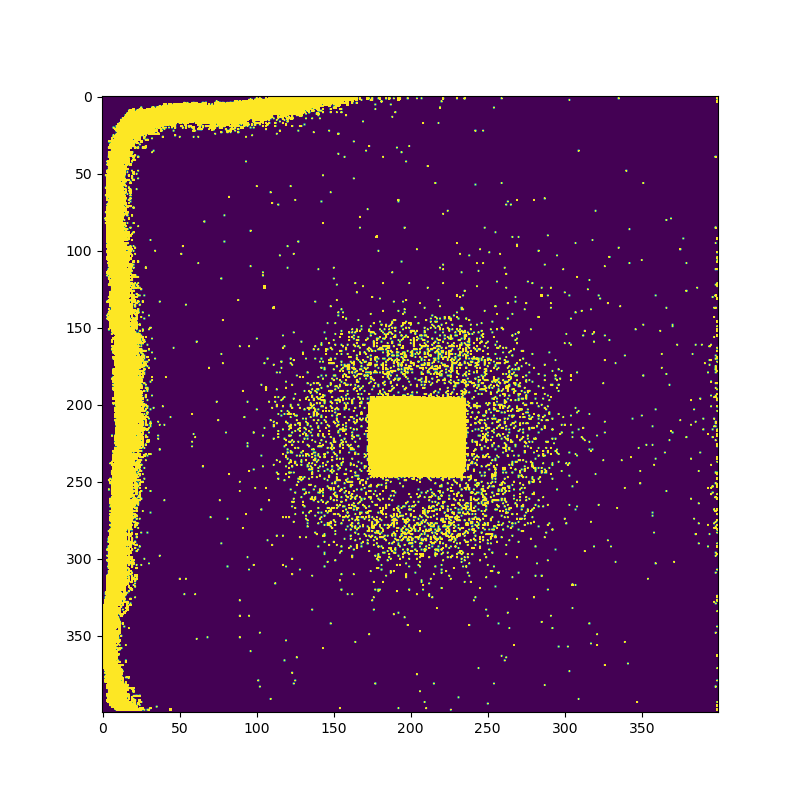

In [19]:
# use the 'Zoom to rectangle' tool to set ROI around the direct beam
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(im3826['pumped'], vmin = 0, vmax = 0.11)

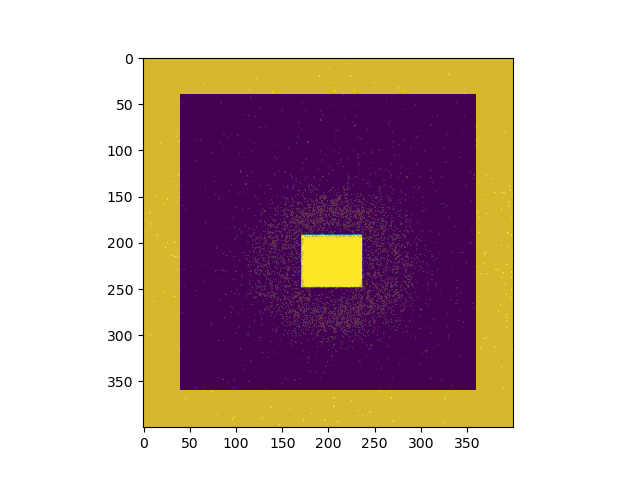

In [21]:
# execute cell only once to save the mask for the Azimuthal Integrator
mask = get_mask()

# just to check, if mask is correctly applie
show_mask_img(im3826, mask)

## Define Center

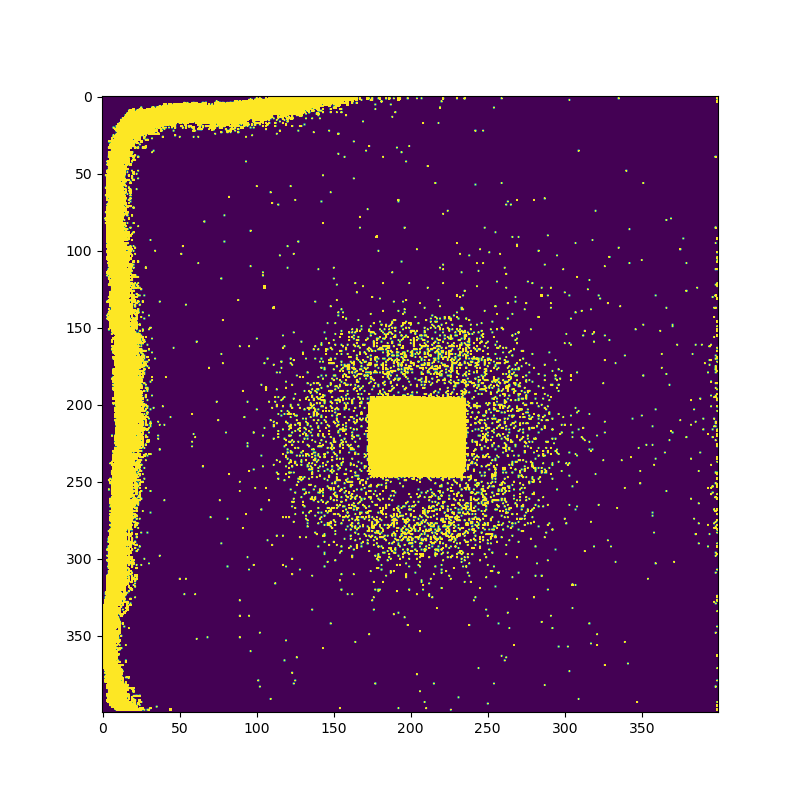

In [22]:
# use the same testimage to correctly get the center of integration
# with the 'zoom to rectangle' tool get the whole scattering ring
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(im3826['pumped'], vmin = 0, vmax = 0.11)

In [23]:
# execute cell only once to save the cneter for the Azimuthal Integrator
center = get_center_pos()

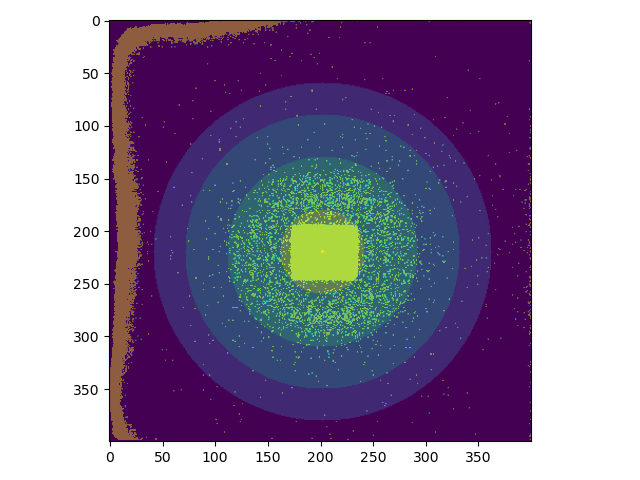

In [24]:
# optical feedback for the set center position and shape of ring
show_center_ring([1,40,90,130,160], im3826, center=center)

## PyFAI Azimuthal Integrator

In [25]:
center = center
px_size = 25e-6
wavelength=1.8e-9
dist=0.27

detector = Detector(px_size, px_size)  # binned!
ai = AzimuthalIntegrator(dist=dist, #Distanz Detektor Probe
                                poni2=center[0] * px_size, #center of the beam, actually... But I have not yet found out which values are transferred there and how.
                                poni1=center[1] * px_size, #center of ray2, just try around until your scattering ring is straight and your q-space starts at 0
                                detector=detector, #detector you have previously defined
                                wavelength=wavelength) # wavelength of x-ray beam

## PyFAI Functions

### get all images from one scan in np.array

In [26]:
def get_all_from_scan(nums, im_path):
    
    '''
    Get an array with all images and 1d integration of a scan.
    
    Params
    ======
    nums: list, int
        numbers of every image in scan
    
    Returns
    =======
    '''
    
    ### initalize arrays for images and Intensitys ###
    all_up = np.zeros((400, 400, len(nums_220)))
    all_p  = np.zeros_like(all_up)

    scan_1dI_up = np.zeros((100, len(nums_220)))
    scan_1dI_p  = np.zeros_like(scan_1dI_up)
    
    
    ### get images, integrate them and write image and intensity to array ###
    for i, num in enumerate(nums):
        
        image = load_image(num, im_path)
    
        all_up[:, :, i] = image['unpumped']
        all_p[:, :, i] = image['pumped']
    
    
        q_up, scan_1dI_up[:, i] = ai.integrate1d(image['unpumped'], unit='q_nm^-1',  npt=100, mask=mask) # npt = number of bins
        q_p, scan_1dI_p[:, i]   = ai.integrate1d(image['pumped'], unit='q_nm^-1', npt=100, mask=mask) # npt = number of bins
        
    return all_up, all_p, q_up, q_p, scan_1dI_up, scan_1dI_p

### Summed integrated ring intensitys from scan

In [27]:
def get_scan_1dseries(ims, path, scan_id = None):
    
    '''
    Get the summed integrated Ring Intensitys of every single picture of a scan.
    
    Params
    ======
    ims: list, int
        list of images belonging to a single scan
    path: string
        path where the images can be found
    scan_id: None or int
        scan numnber found in Sardana
        
    Returns
    =======
    intensitys_unpumped: list of floats
        list with meaned intensitys for each unpumped image of the scan
    intensitys_pumped: list of floats
        list with meaned intensitys for each pumped image of the scan
    q_up: list
        lsit of q-Values from 1d Azimutahl integration of last unpumped image of scan
    q_p: list
        lsit of q-Values from 1d Azimutahl integration of last pumped image of scan
    scan_id: None or int
        scan numnber found in Sardana
    '''
    
    
    
    list_unpumped = []
    list_pumped = []
        
    for image in ims:
        img = load_image(image, path)
        
        img_pumped = img['pumped']
        img_unpumped = img['unpumped']
        
        q_up, I_up = ai.integrate1d(img_unpumped, unit='q_nm^-1',  npt = 100, mask=mask) 
        q_p, I_p = ai.integrate1d(img_pumped, unit='q_nm^-1',  npt = 100, mask=mask)
        
        list_unpumped.append(np.copy(I_up))
        list_pumped.append(np.copy(I_p))

    intensitys_unpumped = np.mean(np.array(list_unpumped), axis=1)
    intensitys_pumped = np.mean(np.array(list_pumped), axis=1)

    if scan_id == None:
        return intensitys_unpumped, intensitys_pumped, q_up, q_p
    else:
        return intensitys_unpumped, intensitys_pumped, q_up, q_p, scan_id

### Fitting 1d integrated curves from scan

In [28]:
def fit_ai1d_scan(ims, path, key = 'unpumped', scan_id=None, min_q=13, max_q=30):
    
    '''
    Fit the Intensity over wavevector for every image in a scan with a  gaussian curve
    
    Params
    ======
    ims: list of int
        list of images belonging to a single scan
    path: string
        path where the images can be found
    key: 'pumped', 'unpumped'
        decides if either pumped or unpumped images should be fitted
    scan_id: None or int
        scan numnber found in Sardana
    min_q: int
        set a minimum value for scattering vector q
    max_q: int
        set a maximum value for scattering vector q
        
    Returns
    =======
    out: dict
        output from the lmfit.models.GaussianModel.fit() function 
    amps: list
        list with amplitudes from gaussian fit for each image in scan
    sigs: list
        list with sigmas from gaussian fit for each image in scan
    cens: list
        list with center positions from gaussian fit for each image in scan
    fwhms: list
        list with FWHM from gaussian fit for each image in scan
    heights: list
        list with heights from gaussian fit for each image in scan
    scan_id:
        if not None returns the scan number
        
    '''
    
    amps    = []
    sigs    = []
    cens    = []
    fwhms   = []
    heights = []
    
    if key == 'unpumped':
        for image in ims:
            img = load_image(image, path)
            img_unpumped = img['unpumped']
            
            ### integrate the image ###
            q_up, I_up = ai.integrate1d(img_unpumped, unit='q_nm^-1',  npt = 100, mask=mask) 
            
            ### setting x range ###
            indexes_q = np.argwhere(np.logical_and(q_up >=min_q/1000, q_up <= max_q/1000))
            
            q_up = q_up[indexes_q]
            I_up = I_up[indexes_q]        
            
            ###  fit every image ###
            
            # bringing x and y in the correct shape / this only is needed because the spahe of I_(un)pumped and q_up is (N, 1)
            # squeeze reduces the dimension of the array so it has shape (N,)
            x = np.squeeze(q_up)
            y = np.squeeze(I_up)
            
            # apply gaussian model
            mod = lm.models.GaussianModel()
            
            # guess the fit params
            pars = mod.guess(y, x=x)
            
            out = mod.fit(y, pars, x=x, nan_policy='propagate')
            
            ### append values to lists ###
            amps.append(out.values['amplitude'])
            sigs.append(out.values['sigma'])
            cens.append(out.values['center'])
            fwhms.append(out.values['fwhm'])
            heights.append(out.values['height'])
    
    if key == 'pumped':
        for image in ims:
            ### load images ###
            img = load_image(image, path)
            img_pumped = img['pumped']
            
            ### integrate the image ###
            q_p, I_p = ai.integrate1d(img_pumped, unit='q_nm^-1',  npt = 100, mask=mask)
            
            ### setting x range ###
            indexes_q = np.argwhere(np.logical_and(q_p >=min_q/1000, q_p <= max_q/1000))
            
            q_p = q_p[indexes_q]
            I_p = I_p[indexes_q]
            
            ### fit every image ###
            
            # bringing x and y in the correct shape / this only is needed because the spahe of I_(un)pumped and q_up is (N, 1)
            # squeeze reduces the dimension of the array so it has shape (N,)
            x = np.squeeze(q_p)
            y = np.squeeze(I_p)
            
            # apply gaussian model
            mod = lm.models.GaussianModel()
            
            # guess the fit params
            pars = mod.guess(y, x=x)
            
            out = mod.fit(y, pars, x=x, nan_policy='propagate')
            
            ### append values to lists ### 
            amps.append(out.values['amplitude'])
            sigs.append(out.values['sigma'])
            cens.append(out.values['center'])
            fwhms.append(out.values['fwhm'])
            heights.append(out.values['height'])
    
    ### returns ###
    if scan_id == None:
        return out, amps, sigs, cens, fwhms, heights
    elif scan_id is not None:
        return out, amps, sigs, cens, fwhms, heights, scan_id

# START OF EVALUATION

# PyFAI 1d Integration

## Single image

### load a single image

In [29]:
img_id = 3855
im3855 = load_image(3855, im_path)

### Integrate

In [30]:
q_up, I_unpumped = ai.integrate1d(im3855['unpumped'], unit='q_nm^-1',  npt = 100, mask=mask) # npt = number of bins
q_p, I_pumped = ai.integrate1d(im3855['pumped'], unit='q_nm^-1', npt = 100, mask=mask) # npt = number of bins

# searching for q indexes where q is less than q1 [um^-1] and greater than q2 [um^-1]
# thus q1 and q2 are divided by 1000, pyfai output is in nm^-1...
indexes_q = np.argwhere(np.logical_and(q_up >=13/1000, q_up <= 100/1000))

q_up = q_up[indexes_q]
q_p = q_p[indexes_q]
I_unpumped = I_unpumped[indexes_q]
I_pumped = I_pumped[indexes_q]

# sum of intensities in integrated area
summe_unpumped = sum(I_unpumped)
summe_pumped = sum(I_pumped)

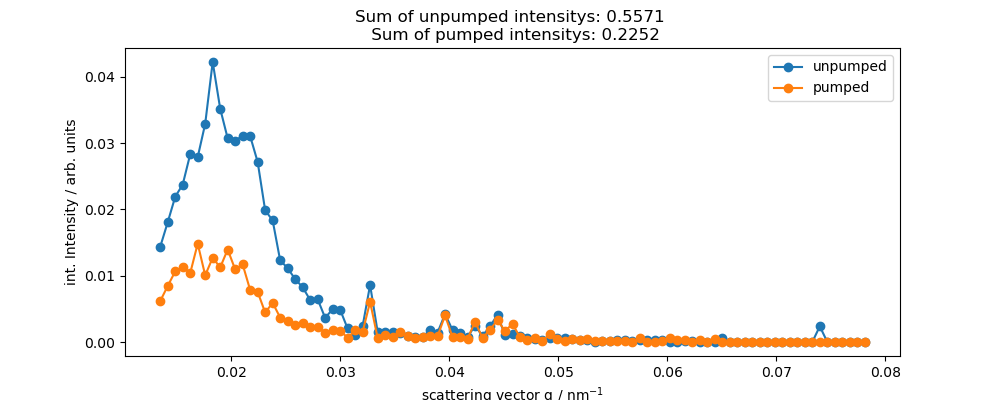

In [31]:
plt.figure(None, (10, 4))
plt.plot(q_up, I_unpumped, 'o-', label='unpumped')
plt.plot(q_p, I_pumped, 'o-', label='pumped')
plt.title('Sum of unpumped intensitys: %.4f \n Sum of pumped intensitys: %.4f' %(summe_unpumped, summe_pumped))
plt.ylabel('int. Intensity / arb. units')
plt.xlabel(r'scattering vector q / nm$^{-1}$')
plt.legend()
plt.savefig('1d_integration_single.png')
plt.show()

### Fitting 1d integration data

#### Gaussian

In [32]:
# bringing x and y in the correct shape / this only is needed because the spahe of I_(un)pumped and q_up is (N, 1)
# squeeze reduces the dimension of the array so it has shape (N,)
x = np.squeeze(q_up)
y_up = np.squeeze(I_unpumped)
y_p = np.squeeze(I_pumped)

mod = lm.models.GaussianModel()

vary = True
pars_up = mod.guess(y_up, x=x)
pars_p = mod.guess(y_p, x=x)

pars = lm.Parameters()

### not needed for standard models and good data ### 
#pars.add('fwhm',         value = 0,      vary = vary)
#pars.add('sigma',     value = 0.0045, vary = vary)
#pars.add('amplitude', value = 0.001,  vary = vary)
#pars.add('center',    value = 0.019,  vary = vary)

out_up = mod.fit(y_up, pars_up, x=x, nan_policy='propagate')
out_p = mod.fit(y_p, pars_p, x=x, nan_policy='propagate')
#out = mod.fit(y_up, pars, x=x, nan_policy='propagate')

# rounds the fit values to 4 digits
vals_up = {key : round(out_up.values[key], 4) for key in out_up.values}   
vals_p = {key : round(out_p.values[key], 4) for key in out_p.values} 

In [48]:
vals_p

{'amplitude': 0.0001,
 'center': 0.018,
 'sigma': 0.0047,
 'fwhm': 0.0111,
 'height': 0.0123}

def fit_get_values(out, key_list):
    
    
    '''
    This function returns the fit values from lmfit.Model.fit.values
     
    Params
    ======
    key_list: list, string
        keys for values which will be taken from values dict
    
    Returns
    =======
    
    '''
    
    vals_up = {key : round(out_up.values[key], 4) for key in out_up.values} 
    
    amp = out_p.values['amplitude']
    sig = out_p.values['sigma']
    cen = out_p.values['center']
    fwhm = out_p.values['fwhm']
    height = out_p.values['height']
    
    vals_p = {key : round(out_p.values[key], 4) for key in out_p.values}

In [33]:
# getting the values of the fit-model for pumped ring
amp = out_p.values['amplitude']
sig = out_p.values['sigma']
cen = out_p.values['center']
fwhm = out_p.values['fwhm']
height = out_p.values['height']
print('amplitude: %.5f, sigma: %.5f, center: %.5f, fwhm: %.5f, height: %.5f' %(amp, sig, cen, fwhm, height))

amplitude: 0.00014, sigma: 0.00454, center: 0.01804, fwhm: 0.01069, height: 0.01249


==================== Best unpumped Fit-Values:{'amplitude': 0.0004, 'center': 0.019, 'sigma': 0.0043, 'fwhm': 0.0102, 'height': 0.0346} ====================
 
 ==================== Best pumped Fit-Values:{'amplitude': 0.0001, 'center': 0.018, 'sigma': 0.0045, 'fwhm': 0.0107, 'height': 0.0125} ====================


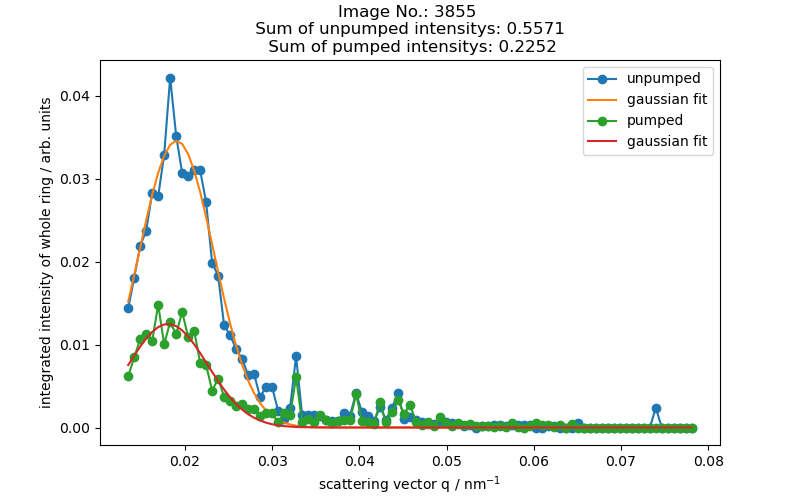

In [34]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.plot(q_up, I_unpumped, 'o-', label='unpumped')
axs.plot(x, out_up.eval(x = x), label='gaussian fit')
axs.plot(q_p, I_pumped, 'o-', label='pumped')
axs.plot(x, out_p.eval(x = x), label='gaussian fit')
axs.set_title('Image No.: %i \n Sum of unpumped intensitys: %.4f \n Sum of pumped intensitys: %.4f' %(img_id, summe_unpumped, summe_pumped))
axs.legend()

axs.set_ylabel('integrated intensity of whole ring / arb. units')
axs.set_xlabel('scattering vector q / nm$^{-1}$')

#axs.set_title('Image no.: %s \n' %img_id + str(vals_up))

#fig.savefig(r'C:\Users\Niklas\MBI\Masterarbeit\Evaluation\trsaxs-master-eval\Eval_pictures\1dIntegrated\gaussian_fit.png')
print('==================== Best unpumped Fit-Values:' + str(vals_up) +' ====================\n \n ==================== Best pumped Fit-Values:' + str(vals_p) +' ====================') 

#### Gaussian Model + linear offset

In [35]:
# bringing x and y in the correct shape / this only is needed because the spahe of I_(un)pumped and q_up is (N, 1)
# squeeze reduces the dimension of the array so it has shape (N,)
x = np.squeeze(q_up)
y_up = np.squeeze(I_unpumped)
y_p = np.squeeze(I_pumped)

mod = lm.models.GaussianModel() + lm.models.ConstantModel()

vary = True
#pars_up = mod.guess(y_up, x=x)
#pars_p = mod.guess(y_p, x=x)

pars = lm.Parameters()

### not needed for standard models and good data ### 
pars.add('c',         value = 0,      vary = vary)
pars.add('sigma',     value = 0.0045, vary = vary)
pars.add('amplitude', value = 0.001,  vary = vary)
pars.add('center',    value = 0.019,  vary = vary)

out_up = mod.fit(y_up, pars, x=x, nan_policy='propagate')
out_p = mod.fit(y_p, pars, x=x, nan_policy='propagate')
#out = mod.fit(y_up, pars, x=x, nan_policy='propagate')

# rounds the fit values to 4 digits
vals_up = {key : round(out_up.values[key], 4) for key in out_up.values}   
vals_p = {key : round(out_p.values[key], 4) for key in out_p.values} 

In [36]:
# getting the values of the fit-model for pumped ring
amp = out_p.values['amplitude']
sig = out_p.values['sigma']
cen = out_p.values['center']
c = out_p.values['c']
print('amplitude: %.4f, sigma: %.4f, center: %.4f, c: %.4f' %(amp, sig, cen, c))

amplitude: 0.0001, sigma: 0.0041, center: 0.0181, c: 0.0007


==================== Best unpumped Fit-Values:{'c': 0.0009, 'sigma': 0.0042, 'amplitude': 0.0004, 'center': 0.019} ====================
 
 ==================== Best pumped Fit-Values:{'c': 0.0007, 'sigma': 0.0041, 'amplitude': 0.0001, 'center': 0.0181} ====================


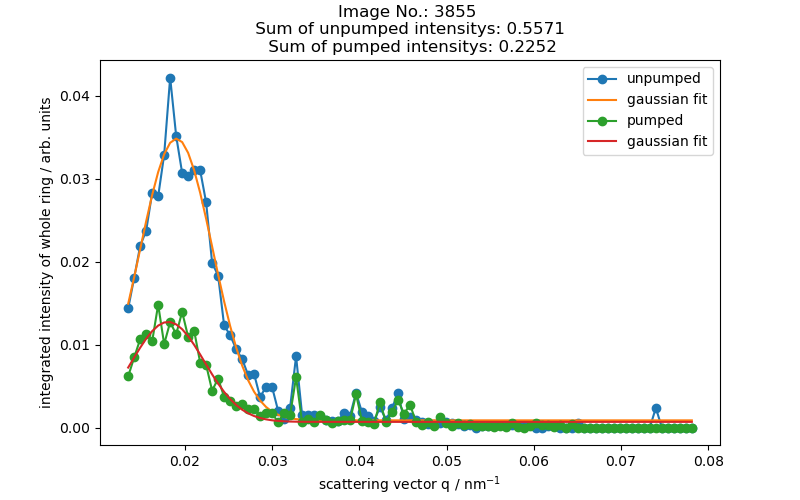

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

axs.plot(q_up, I_unpumped, 'o-', label='unpumped')
axs.plot(x, out_up.eval(x = x), label='gaussian fit')
axs.plot(q_p, I_pumped, 'o-', label='pumped')
axs.plot(x, out_p.eval(x = x), label='gaussian fit')
axs.set_title('Image No.: %i \n Sum of unpumped intensitys: %.4f \n Sum of pumped intensitys: %.4f' %(img_id, summe_unpumped, summe_pumped))
axs.legend()

axs.set_ylabel('integrated intensity of whole ring / arb. units')
axs.set_xlabel('scattering vector q / nm$^{-1}$')

#axs.set_title('Image no.: %s \n' %img_id + str(vals_up))

#fig.savefig(r'C:\Users\Niklas\MBI\Masterarbeit\Evaluation\trsaxs-master-eval\Eval_pictures\1dIntegrated\gaussian_fit.png')
print('==================== Best unpumped Fit-Values:' + str(vals_up) +' ====================\n \n ==================== Best pumped Fit-Values:' + str(vals_p) +' ====================') 

In [47]:
def get_all_from_scan(nums, im_path):
    
    '''
    Get an array with all images and 1d integration of a scan.
    
    Params
    ======
    nums: list, int
        numbers of every image in scan
    
    Returns
    =======
    '''
    
    ### initalize arrays for images and Intensitys ###
    all_up = np.zeros((400, 400, len(nums_220)))
    all_p  = np.zeros_like(all_up)

    scan_1dI_up = np.zeros((100, len(nums_220)))
    scan_1dI_p  = np.zeros_like(scan_1dI_up)
    
    
    ### get images, integrate them and write image and intensity to array ###
    for i, num in enumerate(nums):
        
        image = load_image(num, im_path)
    
        all_up[:, :, i] = image['unpumped']
        all_p[:, :, i] = image['pumped']
    
    
        q_up, scan_1dI_up[:, i] = ai.integrate1d(image['unpumped'], unit='q_nm^-1',  npt=100, mask=mask) # npt = number of bins
        q_p, scan_1dI_p[:, i]   = ai.integrate1d(image['pumped'], unit='q_nm^-1', npt=100, mask=mask) # npt = number of bins
        
    return all_up, all_p, q_up, q_p, scan_1dI_up, scan_1dI_p

##### whole scan 

In [65]:
nums_220 = np.arange(3821, 3864)

all_up, all_p, q_up, q_p, scan_1dI_up, scan_1dI_p = get_all_from_scan(nums_220, im_path)

offsets = []
#outs_up = np.zeros((100, len(nums_220)))
#outs_p = np.zeros_like(outs_up)

for i in arange(len(nums_220)):
    
    x = q_up
    y_up = scan_1dI_up[:, i]
    y_p = scan_1dI_p[:, i]
    
    
    mod = lm.models.GaussianModel() + lm.models.ConstantModel()
    
    pars = lm.Parameters()

    vary = True
    
    pars.add('c',         value = 0.0,      vary = vary)
    pars.add('sigma',     value = 0.005, vary = vary)
    pars.add('amplitude', value = 0.04,  vary = vary)
    pars.add('center',    value = 0.019,  vary = vary)
    
    out_up = mod.fit(y_up, pars, x=x, nan_policy='propagate')
    out_p = mod.fit(y_p, pars, x=x, nan_policy='propagate')
    
    offsets.append(out_up.values['c'])
    #plt.figure()
    #plt.plot(x, scan_1dI_p[:, i])
    #plt.plot(x, out_p.eval(x = x))#, label='gaussian fit')

#### plotting offsets from Fit Model

In [120]:
### x4 to real time ###
x4_time = np.linspace(0, 43*20, 43)

Text(0.5, 1.0, 'Scan ID: 220 \n Max val: 0.0016 \n Min val: 0.0006 \n Avg: 0.0011 \n')

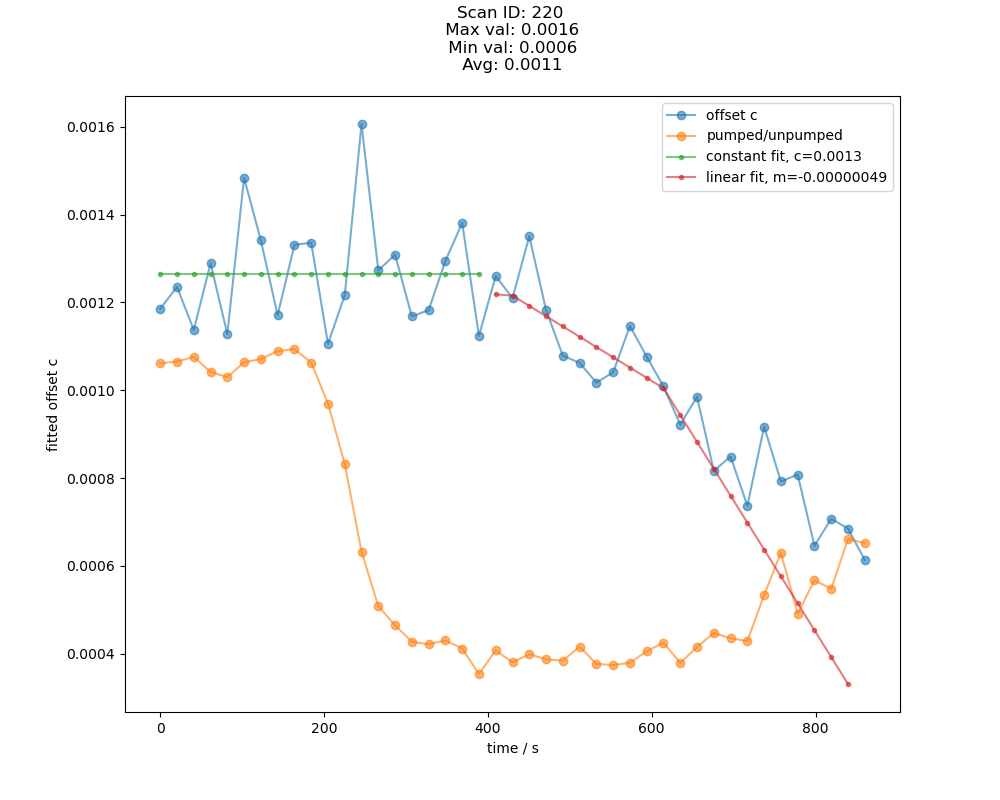

In [245]:
sig = scan_1dI_p.sum(axis=0)/scan_1dI_up.sum(axis=0)*np.mean(offsets)

off_mean = np.mean(offsets)
off_max = max(offsets)
off_min = min(offsets)

### fit the offset with a linear model ###
mod_const = lm.models.ConstantModel()

pars_const = lm.Parameters()

pars_const.add('c',         value = 0.001,      vary = vary)

out_offset_const = mod_const.fit(offsets[:20], pars_const, x=x4_time[:20], nan_policy='propagate')

c = out_offset_const.values['c']
### linear model ###
mod_lin = lm.models.LinearModel()

pars_lin = lm.Parameters()

#pars_lin = mod_lin.guess(offsets[20:-1], x4_time[20:-1])

pars_lin.add('intercept', value=0.00125, vary=False)
pars_lin.add('slope', value=-0.0000002, vary=True)

out_offset_lin = mod_lin.fit(offsets[20:-1], pars_lin, x=x4_time[20:-1]), nan_policy='propagate')

m = out_offset_lin.values['slope']

### plotting ###
fig, axs = plt.subplots(1, figsize=(10, 8))

axs.plot(x4_time, offsets, 'o-', label='offset c', alpha=0.6)
axs.plot(x4_time, sig, 'o-', label='pumped/unpumped', alpha=0.6)
axs.plot(x4_time[:20], np.tile(out_offset_const.eval(x=x4), 20), '.-', alpha=0.6, label='constant fit, c=%.4f' %c)
axs.plot(x4_time[20:-1], out_offset_lin.eval(x=x4[20:-1]), '.-', alpha=0.6, label='linear fit, m=%.8f' %m)
axs.legend()
axs.set_ylabel('fitted offset c')
axs.set_xlabel('time / s')
axs.set_title('Scan ID: 220 \n Max val: %.4f \n Min val: %.4f \n Avg: %.4f \n' %(off_max, off_min, off_mean))

In [242]:
out_offset_lin.values

{'intercept': 0.00125, 'slope': -4.902181680229058e-07}

In [193]:
out_offset_lin.eval(x=x4_time[20:-1])

array([0.001267, 0.001239, 0.00121 , ..., 0.000726, 0.000698, 0.000669])

In [155]:
np.tile(out_offset.eval(x=x4), 20)

(20,)

In [ ]:
for i in arange(0, len(nums_220)):
    print(i)

### Integration???

In [405]:
A = out_p.best_values['amplitude']
sigma = out_p.best_values['sigma']
mu = out_p.best_values['center']

In [406]:
def gauss(A, sigma, mu):
    return A/(sigma*sqrt(2 * np.pi)) * np.exp(-((x-mu)**2)/((2 * sigma)**2))

In [407]:
from scipy import integrate

integrate.quad(gauss(A, sigma, mu), x[0], x[-1])

ValueError: invalid callable given

In [408]:
plt.plot(gauss(A, sigma, mu))

### check every image integration

############ MISC ############

    # searching for q indexes where q is less than q1 [um^-1] and greater than q2 [um^-1]
    # thus q1 and q2 are divided by 1000, pyfai output is in nm^-1...
    indexes_q = np.argwhere(np.logical_and(q_up >=13/1000, q_up <= 70/1000))

    q_up = q_up[indexes_q]
    q_p = q_p[indexes_q]
    I_unpumped = I_unpumped[indexes_q]
    I_pumped = I_pumped[indexes_q]
    
    # sum
    summe_unpumped = sum(I_unpumped)
    summe_pumped = sum(I_pumped)
    
    x = np.squeeze(q_up)
    y_up = np.squeeze(I_unpumped)
    y_p = np.squeeze(I_pumped)

    mod = lm.models.GaussianModel()

    #vary = False
    pars_up = mod.guess(y_up, x=x)
    pars_p = mod.guess(y_p, x=x)
    
    ### not needed for standard models and good data ### 
    #pars.add('width',  value = (0.3+0.7)/2.0,   vary = vary)
    #pars.add('sigma', value = (0.7-0.3)/9.0,   vary = vary)
    #pars.add('amplitude',   value = -0.3       ,   vary = vary)
    #pars.add('center',   value = 1.0        ,   vary = vary)

    out_up = mod.fit(y_up, pars_up, x=x, nan_policy='propagate')
    out_p = mod.fit(y_p, pars_p, x=x, nan_policy='propagate')

    # rounds the fit values to 4 digits
    vals_up = {key : round(out_up.values[key], 10) for key in out_up.values}   
    vals_p = {key : round(out_p.values[key], 10) for key in out_p.values} 
    #print('Values for unpumped images:' +str(vals_up))
    #print('Values for pumped images:' +str(vals_p) + '\n')
    
    fig, axs = plt.subplots(1, 1, figsize=(8, 5))

    axs.plot(q_up, I_unpumped, 'o-', label='unpumped')
    axs.plot(x, out_up.eval(x = x), label='gaussian fit')
    axs.plot(q_p, I_pumped, 'o-', label='pumped')
    axs.plot(x, out_p.eval(x = x), label='gaussian fit')
    axs.legend()

    axs.set_ylabel('integrated intensity of whole ring / arb. units')
    axs.set_xlabel('scattering vector q / nm$^{-1}$')

    axs.set_title('Image no.: %s \n' %num + str(vals_up))
    
    sums_unpumped.append(summe_unpumped)
    sums_pumped.append(summe_pumped)

### pcolormesh from each single image

In [293]:
nums_220 = np.arange(3821, 3864)

# gettimg the scan as numpy array
all_up, all_p, q_up, q_p, scan_1dI_up, scan_1dI_p = get_all_from_scan(nums_220, im_path)

In [247]:
norm = np.tile(np.sum(scan_1dI_up, axis=0), [100, 1])
x4_mesh = np.tile(x4, [100, 1])

indexes_q = np.argwhere(np.logical_and(q_up >=13/1000, q_up <= 100/1000))

q_up = q_up[indexes_q]
q_p = q_p[indexes_q]

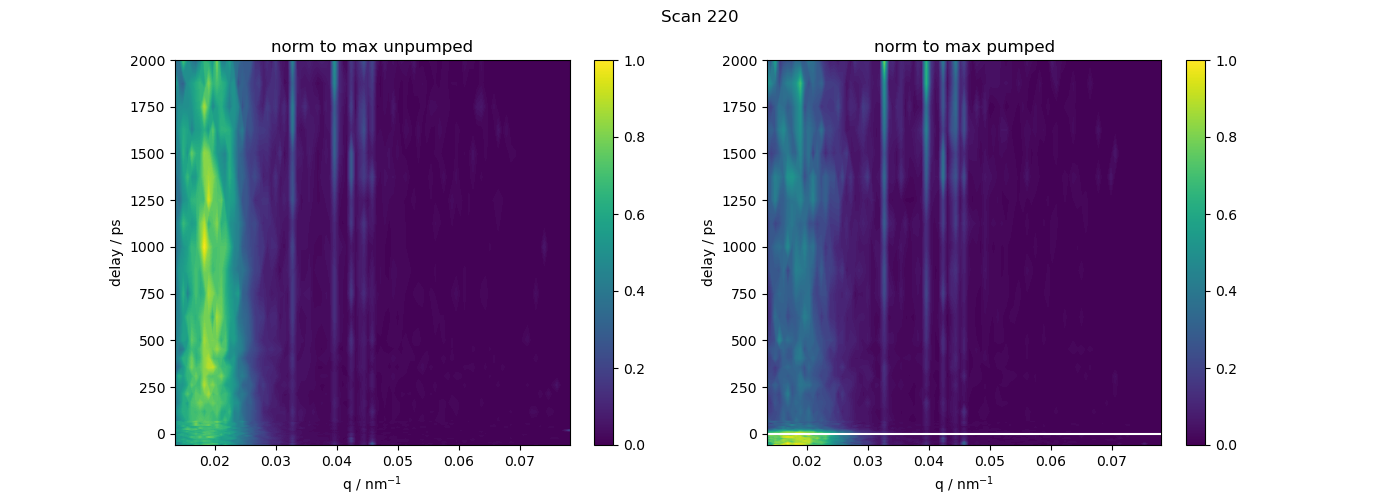

In [248]:
X, Y = np.meshgrid(np.linspace(q_up[0], q_up[-1], len(q_up)), x4)

fig, axs = plt.subplots(1, 2, figsize=(14, 5))
#axs[0].imshow(all_p[:, :, 0])
axs[0].contourf(X, Y, (scan_1dI_up[np.squeeze(indexes_q, axis=1)]/norm[np.squeeze(indexes_q, axis=1)]).transpose(), cmap='viridis', levels=100)
axs[0].set_ylabel('delay / ps')
axs[0].set_xlabel('q / nm$^{-1}$')
axs[0].set_title('norm to max unpumped')
#axs[0].set_yscale('semilog')
fig.colorbar(cm.ScalarMappable(norm=None, cmap='viridis'), ax=axs[0])

fig.suptitle('Scan 220')

axs[1].contourf(X, Y, (scan_1dI_p[np.squeeze(indexes_q, axis=1)]/norm[np.squeeze(indexes_q, axis=1)]).transpose(), cmap='viridis', levels=100)
axs[1].set_ylabel('delay / ps')
axs[1].set_xlabel('q / nm$^{-1}$')
axs[1].set_title('norm to max pumped')
axs[1].axhline(0, c='white')
fig.colorbar(cm.ScalarMappable(norm=None, cmap='viridis'), ax=axs[1])

#### sum of pumped/unpumped intensitys

In [298]:
def get_new_qrange(q_min, q_max, q_up=q_up, q_p=q_p, I1d_up=scan_1dI_up, I1d_p=scan_1dI_p):
    
    indexes_q = np.argwhere(np.logical_and(q_up >=q_min/1000, q_up <= q_max/1000))

    q_up = np.squeeze(q_up[indexes_q].copy(), axis=1)
    q_p = np.squeeze(q_p[indexes_q].copy(), axis=1)
    I1d_up = np.squeeze(I1d_up[indexes_q].copy(), axis=1)
    I1d_p = np.squeeze(I1d_p[indexes_q].copy(), axis=1)
    
    return q_up, q_p, I1d_up, I1d_p

In [347]:
all_up, all_p, q_up, q_p, scan_1dI_up, scan_1dI_p = get_all_from_scan(nums_220, im_path)

print(scan_1dI_p.shape)

qs = get_new_qrange(0, 30)

summed_1d_up = qs[2].sum(axis=0)
summed_1d_p = qs[3].sum(axis=0)

(100, 43)


In [363]:
qs[3].shape

(30, 43)

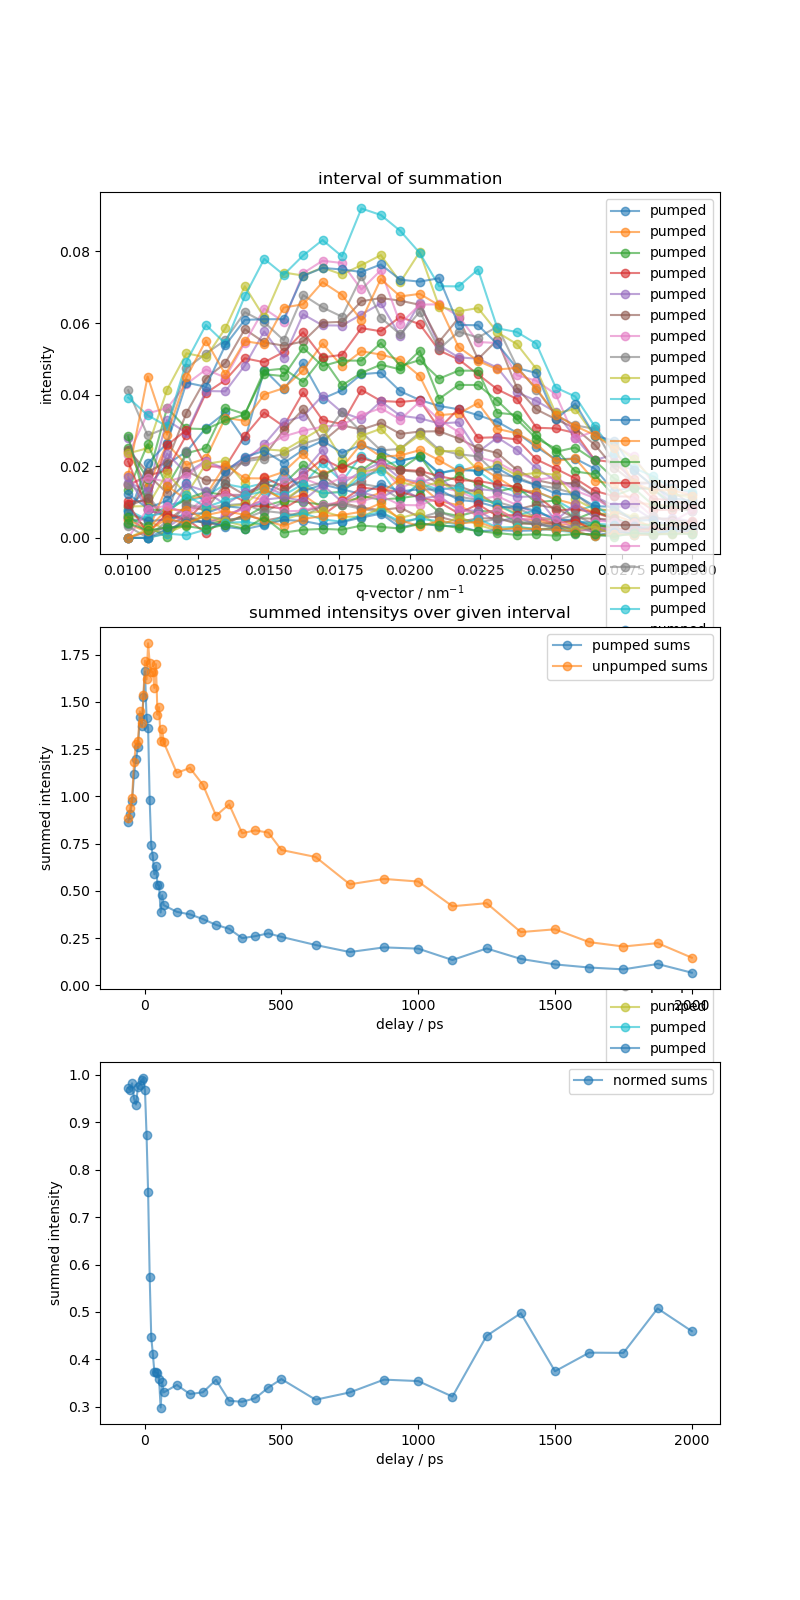

In [369]:
fig, axs = plt.subplots(3,1, figsize=(8, 16))

axs[0].plot(qs[0], qs[3], 'o-', alpha=0.6, label='pumped')
axs[0].set_ylabel('intensity')
axs[0].set_xlabel('q-vector / nm$^{-1}$')
axs[0].set_title('interval of summation')
axs[0].legend()

axs[1].plot(x4, (summed_1d_p), 'o-', alpha=0.6, label='pumped sums')
axs[1].plot(x4, (summed_1d_up), 'o-', alpha=0.6, label='unpumped sums')
axs[1].set_title('summed intensitys over given interval')
axs[1].set_ylabel('summed intensity')
axs[1].set_xlabel('delay / ps')
axs[1].legend()

axs[2].plot(x4, (summed_1d_p)/(summed_1d_up), 'o-', alpha=0.6, label='normed sums')
axs[2].set_ylabel('summed intensity')
axs[2].set_xlabel('delay / ps')
axs[2].legend()


plt.legend()
plt.show()

## Full Scan

### PyFAI 1d full scan

### fit full scan 1d integrated data with gaussian

In [339]:
# nums of scan 220
nums_220 = np.arange(3821, 3864)

# fitting every image of scan with gaussian
out_up, amps_up, sigs_up, cens_up, fwhms_up, heights_up, scan_id = fit_ai1d_scan(nums_220, im_path, scan_id=220, key='unpumped')
out_p, amps_p, sigs_p, cens_p, fwhms_p, heights_p, scan_id = fit_ai1d_scan(nums_220, im_path,scan_id=220, key='pumped')

Text(0.5, 0.98, 'Scan No: 220')

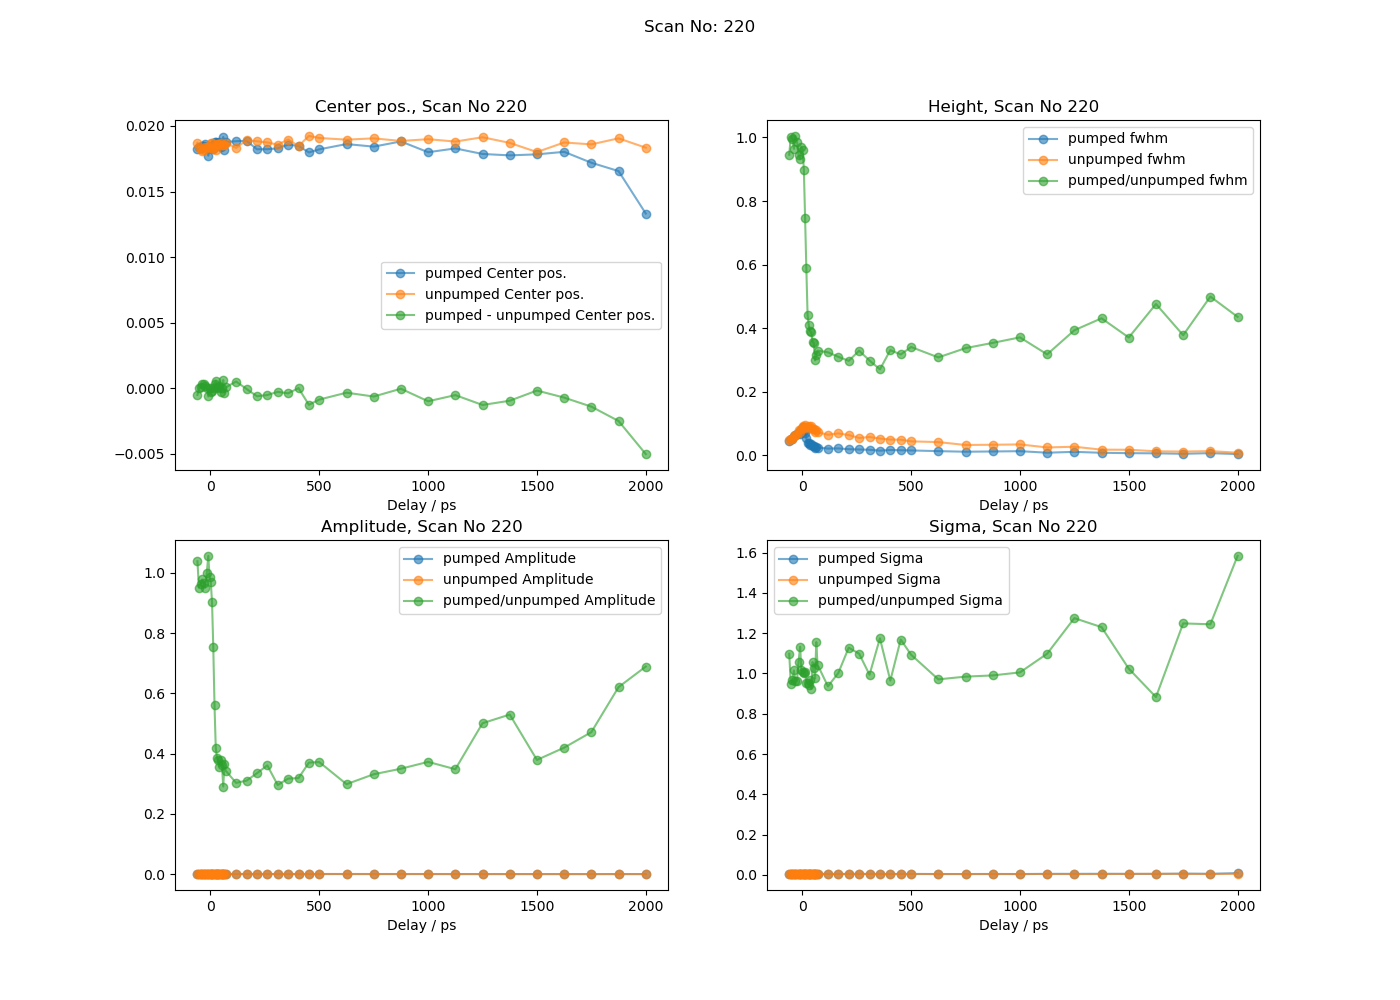

In [348]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0,0].plot(x4, cens_p, 'o-', label='pumped Center pos.', alpha=0.6)
axs[0,0].plot(x4, cens_up, 'o-', label='unpumped Center pos.', alpha=0.6)
axs[0,0].plot(x4, np.array(cens_p)-np.array(cens_up), 'o-', label='pumped - unpumped Center pos.', alpha=0.6)
axs[0,0].set_xlabel('Delay / ps')
axs[0,0].legend()
axs[0,0].set_title('Center pos., Scan No %i' %scan_id)

axs[0,1].plot(x4, heights_p, 'o-', label='pumped fwhm', alpha=0.6)
axs[0,1].plot(x4, heights_up, 'o-', label='unpumped fwhm', alpha=0.6)
axs[0,1].plot(x4, np.array(heights_p)/np.array(heights_up), 'o-', label='pumped/unpumped fwhm', alpha=0.6)
axs[0,1].set_xlabel('Delay / ps')
axs[0,1].legend()
axs[0,1].set_title('Height, Scan No %i' %scan_id)

axs[1,0].plot(x4, amps_p, 'o-', label='pumped Amplitude', alpha=0.6)
axs[1,0].plot(x4, amps_up, 'o-', label='unpumped Amplitude', alpha=0.6)
axs[1,0].plot(x4, np.array(amps_p)/np.array(amps_up), 'o-', label='pumped/unpumped Amplitude', alpha=0.6)
axs[1,0].set_xlabel('Delay / ps')
axs[1,0].legend()
axs[1,0].set_title('Amplitude, Scan No %i' %scan_id)

axs[1,1].plot(x4, sigs_p, 'o-', label='pumped Sigma', alpha=0.6)
axs[1,1].plot(x4, sigs_up, 'o-', label='unpumped Sigma', alpha=0.6)
axs[1,1].plot(x4, np.array(sigs_p)/np.array(sigs_up), 'o-', label='pumped/unpumped Sigma', alpha=0.6)
axs[1,1].set_xlabel('Delay / ps')
axs[1,1].legend()
axs[1,1].set_title('Sigma, Scan No %i' %scan_id)




fig.suptitle('Scan No: %i' %scan_id)
#fig.savefig(r'C:\Users\Niklas\MBI\Masterarbeit\Evaluation\trsaxs-master-eval\Eval_pictures\1dIntegrated\gaussian_fit_values_for_scan.png')
#plt.ylabel()

# PyFAI 2d integration

## Single Image

In [ ]:
unpumped_2d, radial, azimuthal = ai.integrate2d(im3826['unpumped'], 100, unit='q_nm^-1', mask=mask)
pumped_2d, radial, azimuthal = ai.integrate2d(im3826['pumped'], 100, unit='q_nm^-1', mask=mask)

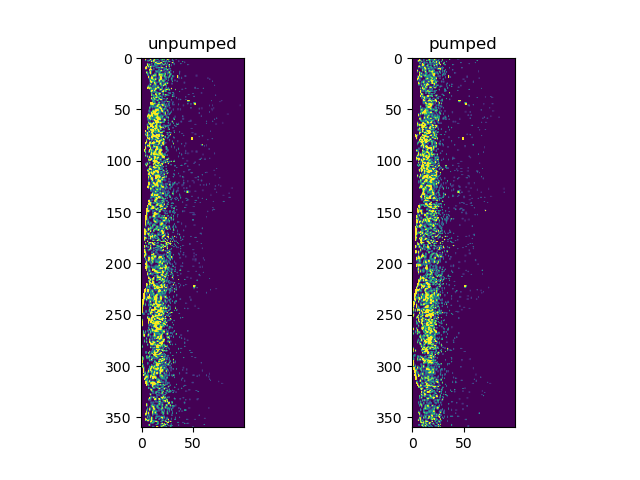

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(unpumped_2d, vmin=0, vmax = 0.11)
ax2.imshow(pumped_2d, vmin=0, vmax = 0.11)
ax1.set_title('unpumped')
ax2.set_title('pumped')
#ax1.set_ylabel('angle of integration')
#ax2.set_ylabel('angle of integration')
#ax1.set_xlabel(r'scattering vector q / nm$^{-1}$')
#ax2.set_xlabel(r'scattering vector q / nm$^{-1}$')
plt.savefig('2d_integration single.png')

### Save Full Ring figures

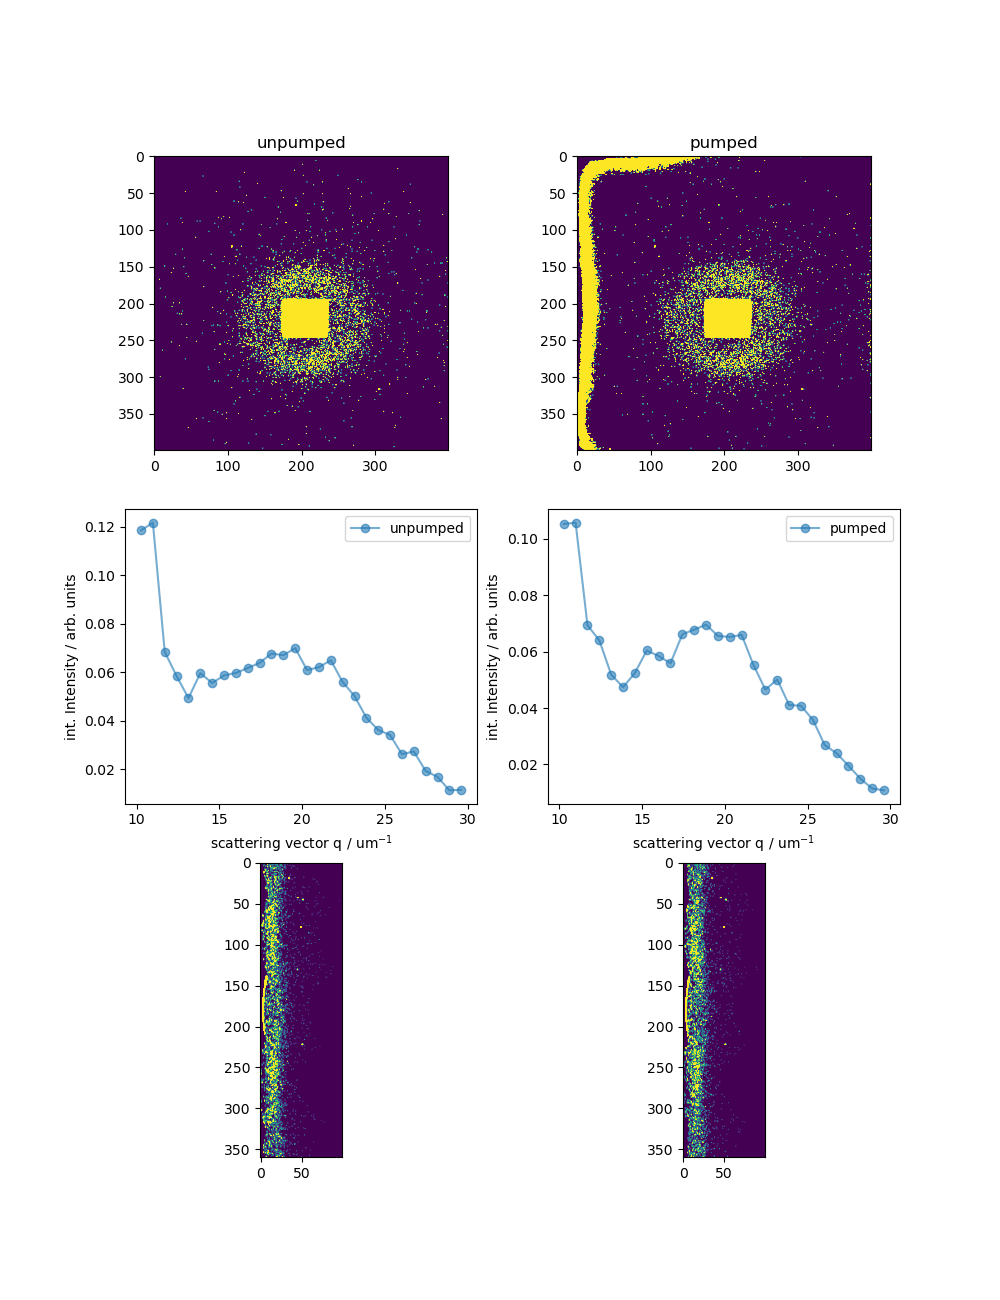

In [51]:
plt.tight_layout()

fig, axs = plt.subplots(3,2, figsize=(10, 13), gridspec_kw={'width_ratios': [10, 10]})
axs[1,0].plot(q_up*1000, I_unpumped, 'o-', label='unpumped', alpha=0.6)
axs[1,1].plot(q_p*1000, I_pumped, 'o-', label='pumped', alpha=0.6)
axs[1,1].set_ylabel('int. Intensity / arb. units')
axs[1,0].set_ylabel('int. Intensity / arb. units')
axs[1,1].set_xlabel(r'scattering vector q / um$^{-1}$')
axs[1,0].set_xlabel(r'scattering vector q / um$^{-1}$')
axs[1,0].legend()
axs[1,1].legend()
axs[2,0].imshow(unpumped_2d, vmin=0, vmax = 0.11)
axs[2,1].imshow(pumped_2d, vmin=0, vmax = 0.11)
axs[0,0].set_title('unpumped')
axs[0,1].set_title('pumped')
axs[0,0].imshow(im3826['unpumped'], vmin = 0, vmax = 0.11)
axs[0,1].imshow(im3826['pumped'], vmin = 0, vmax = 0.11)

fig.savefig('all_together.png')

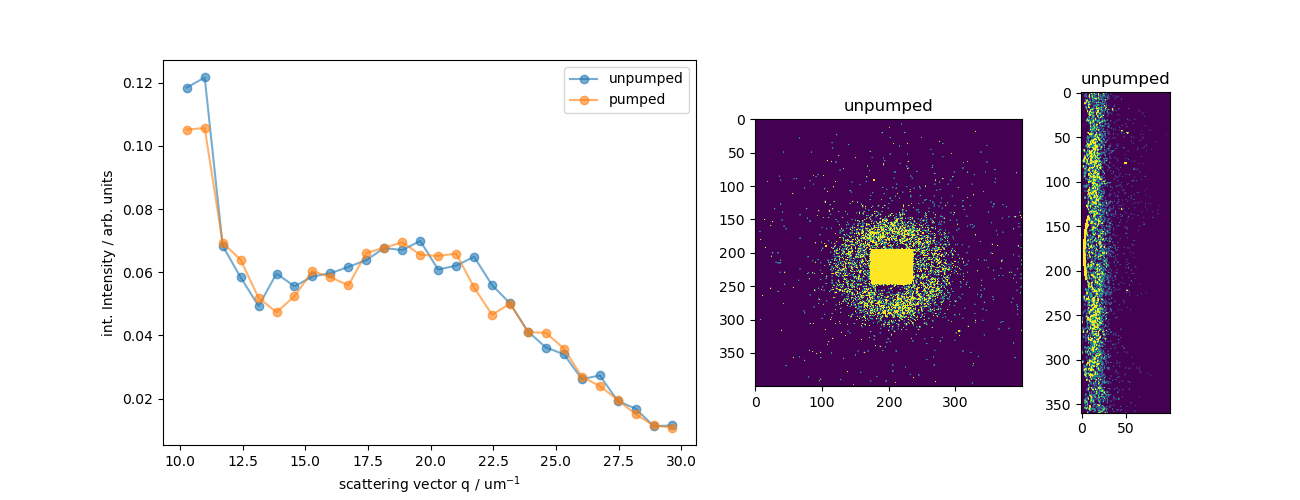

In [52]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize=(13, 5), gridspec_kw={'width_ratios': [12, 6, 2], 'height_ratios': [1]})

ax1.plot(q_up*1000, I_unpumped, 'o-', label='unpumped', alpha=0.6)
ax1.plot(q_p*1000, I_pumped, 'o-', label='pumped', alpha=0.6)
ax1.set_ylabel('int. Intensity / arb. units')
ax1.set_xlabel(r'scattering vector q / um$^{-1}$')
ax1.legend()
ax2.imshow(im3826['unpumped'], vmin = 0, vmax = 0.11)
ax3.imshow(unpumped_2d, vmin=0, vmax = 0.11)
ax2.set_title('unpumped')
ax3.set_title('unpumped')
plt.savefig('unpumped_ring.png')


### Masking the Data to integrator over specific area

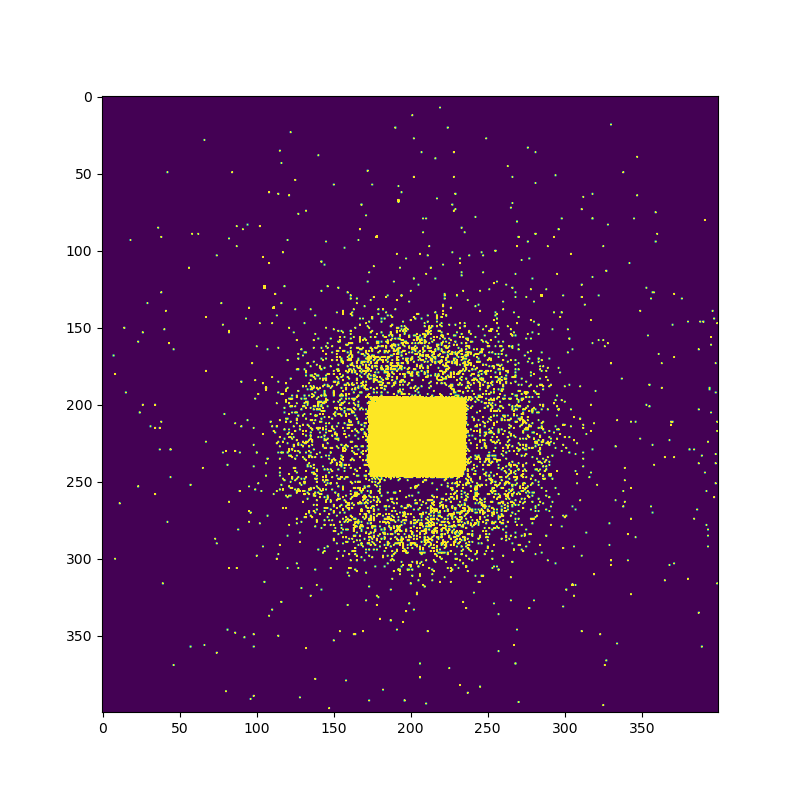

In [171]:
# use the 'Zoom to rectangle' tool to set ROI around the direct beam
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(im3826['unpumped'], vmin = 0, vmax = 0.11)
#fig.savefig('simulated_ring.png')

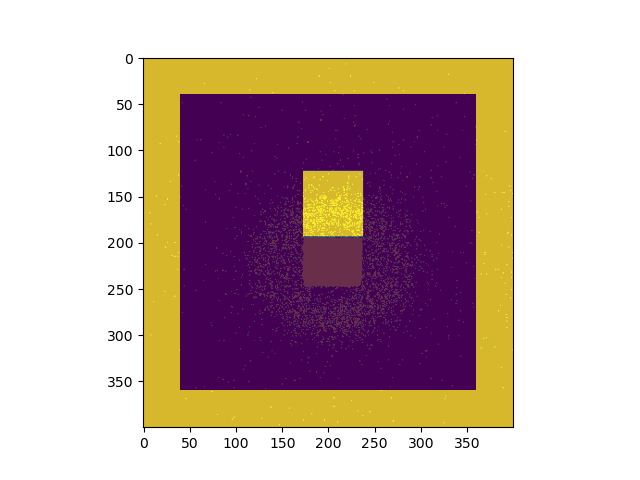

In [172]:
# execute cell only once to save the mask for the Azimuthal Integrator
mask = get_mask()

# just to check, if mask is correctly applie
show_mask_img(im3826, mask)

In [173]:
new_mask = invert_mask(mask)

In [174]:
q_masked, I_masked = ai.integrate1d(im3826['unpumped'], 40, mask = new_mask)
output_masked = ai.integrate2d(im3826['unpumped'], 40, azimuth_range=(-180, 180), npt_azim = 360, mask=new_mask)

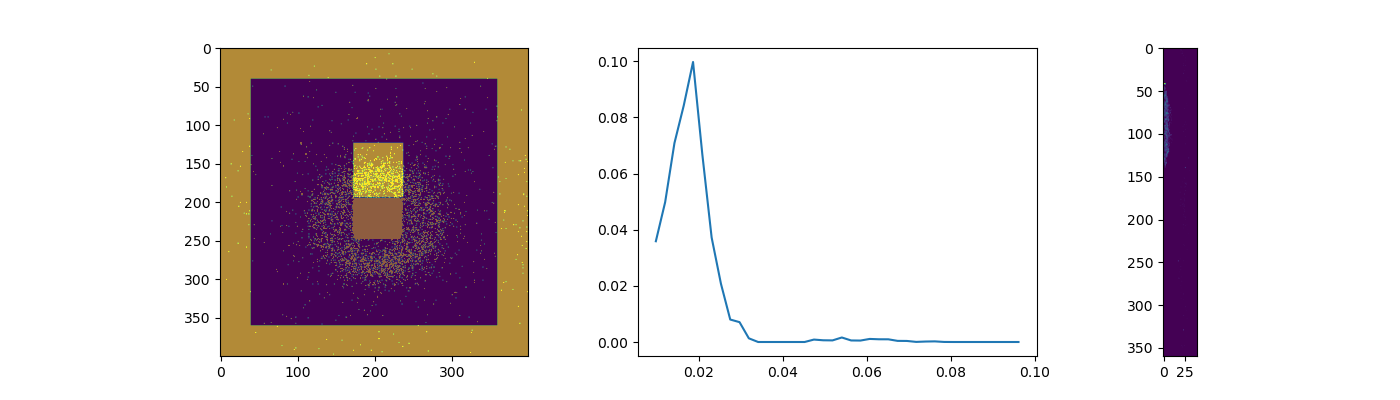

In [178]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [10, 10, 4]})
axs[0].imshow(im3826['unpumped'], vmin = 0, vmax = 0.11)
axs[0].imshow(mask, alpha=0.6)
axs[1].plot(q_masked, I_masked)
axs[2].imshow(output_masked[0])
plt.savefig(r'C:/Users/Niklas/Documents/MBI/Master Arbeit/Evaluation/Eval_pictures/test.png')

## Full scans

### Load full scan

In [174]:
# load single full scan
nums = np.arange(3821, 3865)
mean_up, mean_p, vmin_97 , vmax_97 = get_meaned_scan(nums, im_path, 0, 97)

# comparison
mean_up, mean_p, vmin_90 , vmax_90 = get_meaned_scan(nums, im_path, 0, 90)
mean_up, mean_p, vmin_99 , vmax_99 = get_meaned_scan(nums, im_path, 0, 99.9)

Text(0.5, 1.0, 'Percentile (0, 99)%')

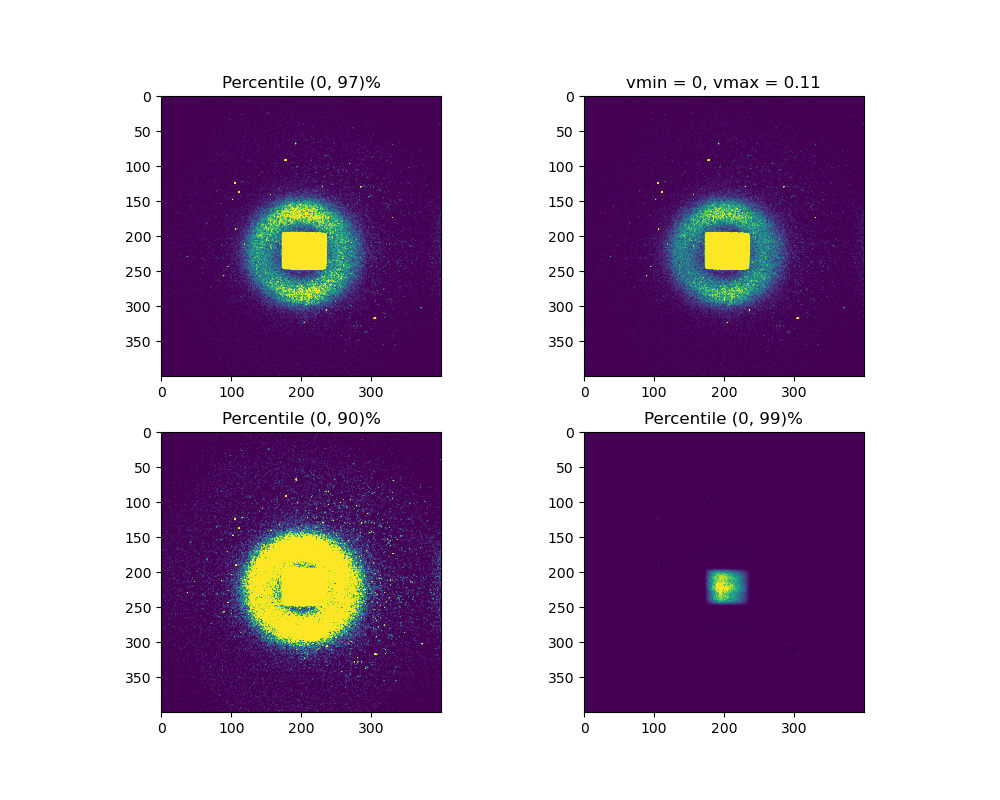

In [175]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))#, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]})

axs[0, 0].imshow(mean_up, vmin=vmin_97, vmax=vmax_97)
axs[0, 0].set_title('Percentile (0, 97)%')
axs[0, 1].imshow(mean_up, vmin=0, vmax=0.1)
axs[0, 1].set_title('vmin = 0, vmax = 0.11')
axs[1, 0].imshow(mean_up, vmin=vmin_90, vmax=vmax_90)
axs[1, 0].set_title('Percentile (0, 90)%')
axs[1, 1].imshow(mean_up, vmin=vmin_99, vmax=vmax_99)
axs[1, 1].set_title('Percentile (0, 99)%')
#fig.savefig(r'C:\Users\Niklas\Documents\MBI\Master Arbeit\Evaluation\Eval_pictures\full_scan_percentile_vs_vmin_vmax_2.png')

### 2d PyFAI full Scans

In [170]:
nums_220 = np.arange(3821, 3864)
mean_up_220, mean_p_220, vmin , vmax = get_meaned_scan(nums, im_path, 0, 97)

In [171]:
q_up_220, I_up_220 = ai.integrate1d(mean_up_220, unit='q_nm^-1',  npt = 100, mask=mask) # npt = number of bins
q_p_220, I_p_220 = ai.integrate1d(mean_p_220, unit='q_nm^-1', npt = 100, mask=mask) # npt = number of bins

# searching for q indexes where q is less than q1 [um^-1] and greater than q2 [um^-1]
# thus q1 and q2 are divided by 1000, pyfai output is in nm^-1...
indexes_q = np.argwhere(np.logical_and(q_up_220 >=5/1000, q_up_220 <= 35/1000))

q_up_220 = q_up_220[indexes_q]
q_p_220 = q_p_220[indexes_q]
I_up_220 = I_up_220[indexes_q]
I_p_220 = I_p_220[indexes_q]

In [172]:
up_2d_220, radial, azimuthal = ai.integrate2d(mean_up_220, 100, unit='q_nm^-1', mask=mask)
p_2d_220, radial, azimuthal = ai.integrate2d(mean_p_220, 100, unit='q_nm^-1', mask=mask)

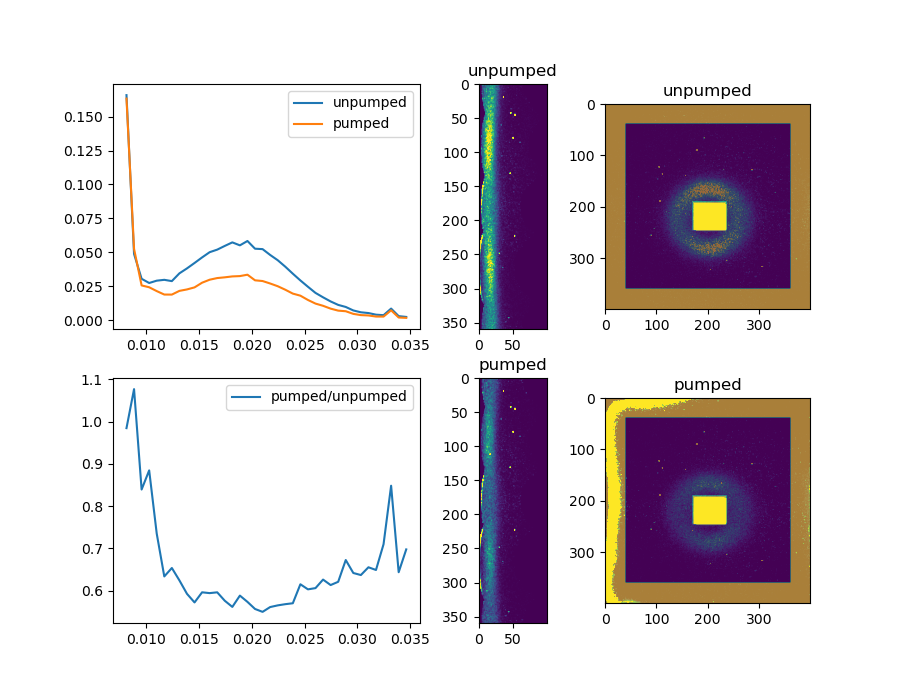

In [173]:
fig, axs = plt.subplots(2, 3, figsize=(9, 7), gridspec_kw={'width_ratios': [6, 2,4]})

axs[0, 0].plot(q_up_220, I_up_220, label='unpumped')
axs[0, 0].plot(q_p_220, I_p_220, label='pumped')
axs[0, 1].imshow(up_2d_220, vmin = vmin, vmax = vmax)
axs[0, 1].set_title('unpumped')
axs[0, 2].imshow(mean_up_220, vmin = vmin, vmax = vmax)
axs[0, 2].set_title('unpumped')
axs[0, 2].imshow(mask, alpha=0.55)
axs[0, 0].legend()


axs[1, 0].plot(q_p_220, I_p_220/I_up_220, label='pumped/unpumped')
axs[1, 1].imshow(p_2d_220, vmin = vmin, vmax = vmax)
axs[1, 1].set_title('pumped')
axs[1, 2].imshow(mean_p_220 ,vmin = vmin, vmax = vmax)
axs[1, 2].set_title('pumped')
axs[1, 2].imshow(mask, alpha=0.55)
axs[1, 0].legend()

In [175]:
I_up, I_p, q_up, q_p = get_scan_1dseries(nums_220, im_path)   

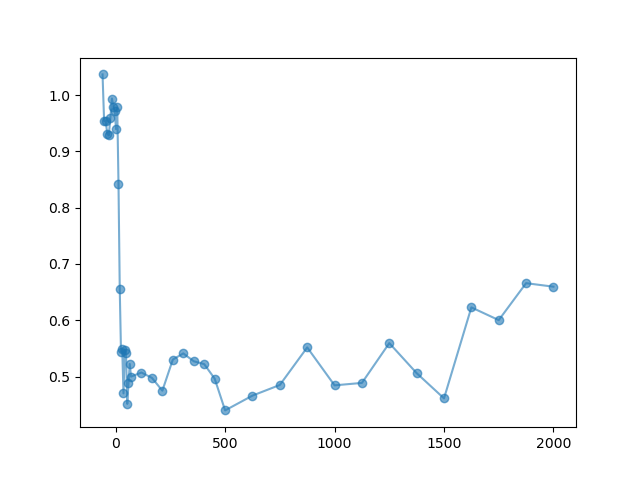

In [177]:
command4 = '-60.0 [[-10.0 7] [70.0 14] [500.0 9] [2000.0 12]]'  # 37 pts .
x4 = get_interval_from_sardana(command4)

plt.figure()
plt.plot(x4, I_p/I_up, '-o', alpha=0.6)
plt.show()

# Misc

In [243]:
def mask_out_ring_V2(f, center, rmin, rmax):
    
    h,w = f.shape
    cy,cx = center
    g = np.copy(f)
    g = 0
    
    ys,xs = np.meshgrid(np.arange(h),np.arange(w), indexing="ij")
    
    dist = np.sqrt((xs-cx)**2 + (ys-cy)**2)
    
    inds = np.where((dist >= rmin) & (dist <= rmax))
    
    g[inds] = 1.0
    
    return g

In [244]:
ring_mask = mask_out_ring_V2(im3826['unpumped'], (202, 220), 0, 0.2)

TypeError: 'int' object does not support item assignment

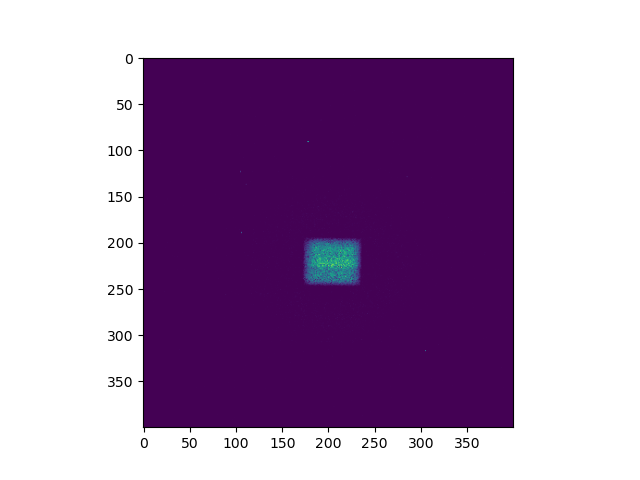

In [240]:
plt.figure()
plt.imshow(ring_mask)

In [ ]:
def ai_1d(scan_id, nums):
    
    nums = nums
    mean_up, mean_p, vmin_962 , vmax_962 = get_meaned_scan(nums, im_path, 0, 97)
    
    q_up_220, I_up_220 = ai.integrate1d(mean_up_220, unit='q_nm^-1',  npt = 100, mask=mask) # npt = number of bins
    q_p_220, I_p_220 = ai.integrate1d(mean_p_220, unit='q_nm^-1', npt = 100, mask=mask) # npt = number of bins

    # searching for q indexes where q is less than q1 [um^-1] and greater than q2 [um^-1]
    # thus q1 and q2 are divided by 1000, pyfai output is in nm^-1...
    indexes_q = np.argwhere(np.logical_and(q_up_220 >=5/1000, q_up_220 <= 35/1000))

    q_up_220 = q_up_220[indexes_q]
    q_p_220 = q_p_220[indexes_q]
    I_up_220 = I_up_220[indexes_q]
    I_p_220 = I_p_220[indexes_q]